# Understanding RNNs

<img src="./resources/RNN-basic-schema.png"/>

The process described on the picture above corresponds to an actual Keras layer: the `SimpleRNN` layer:

In [1]:
from tensorflow.keras.layers import SimpleRNN

`SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence. This means that it takes inputs of shape (`batch_size, timesteps, input_features`), rather than (`timesteps, input_features`).

Like all recurrent layers in Keras, **`SimpleRNN` can be run in two different modes**: 
- it can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape (`batch_size, timesteps, output_features`));
- it can return only the last output for each input sequence (a 2D tensor of shape (`batch_size, output_features`)). These two modes are controlled by the return_sequences constructor argument. 

Let's take a look at an example per each type. This one returns only the last output for each input sequence:

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))       # the dimensionality of the embeddings, here 32. 
model.add(SimpleRNN(32))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


while this returns the full sequences of successive outputs for each timestep:

In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to **stack several recurrent layers one after the other in order to increase the representational power of a network**. In such a setup, **you have to get all intermediate layers to return full sequences**:

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [6]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)

print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17464789/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [7]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 25s 152ms/step - loss: 0.6638 - acc: 0.5877 - val_loss: 0.5866 - val_acc: 0.7040
Epoch 2/10
157/157 [==============================] - 23s 147ms/step - loss: 0.4493 - acc: 0.8030 - val_loss: 0.3792 - val_acc: 0.8432
Epoch 3/10
157/157 [==============================] - 22s 140ms/step - loss: 0.3073 - acc: 0.8772 - val_loss: 0.3832 - val_acc: 0.8302
Epoch 4/10
157/157 [==============================] - 22s 140ms/step - loss: 0.2368 - acc: 0.9104 - val_loss: 0.3978 - val_acc: 0.8356
Epoch 5/10
157/157 [==============================] - 21s 136ms/step - loss: 0.1695 - acc: 0.9388 - val_loss: 0.4282 - val_acc: 0.8206
Epoch 6/10
157/157 [==============================] - 22s 138ms/step - loss: 0.1131 - acc: 0.9617 - val_loss: 0.5845 - val_acc: 0.7608
Epoch 7/10
157/157 [==============================] - 22s 138ms/step - loss: 0.0708 - acc: 0.9776 - val_loss: 0.4779 - val_acc: 0.8476
Epoch 8/10
157/157 [==============================] - 2

Let's plot the validation loss and accuracy:

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')   #“bo” is for “blue dot.
    plt.plot(epochs, val_acc, 'b', label='Validation acc') #“b” is for “solid blue line.”
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

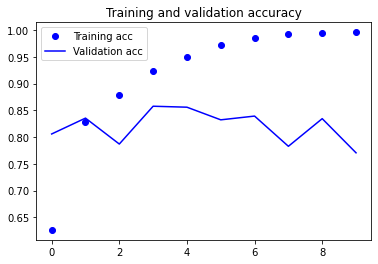

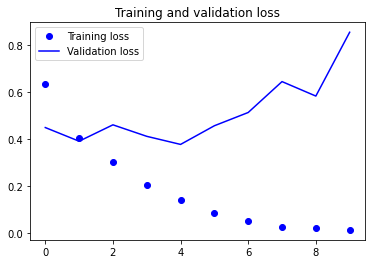

In [ ]:
plot_loss_accuracy(history)

As a reminder, in chapter 3, **our very first naive approach to this very dataset got us to 88% test accuracy**. Unfortunately, our small recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is that **our inputs only consider the first 500 words rather the full sequences** -- hence **our RNN has access to less information than our earlier baseline model**. The remainder of the problem is simply that **`SimpleRNN` isn't very good at processing long sequences, like text**. Other types of recurrent layers perform much better. 

Let's take a look at some more advanced layers.

### LSTM: a concrete example in Keras

Now let's switch to more practical concerns: we will set up a model using a `LSTM` layer and train it on the IMDB data. The network is similar to the one with `SimpleRNN`, and we only specify the output dimensionality of the LSTM layer, and leave every other argument (there are lots) to the Keras defaults.

In [ ]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 43s 2ms/sample - loss: 0.5148 - acc: 0.7533 - val_loss: 0.4401 - val_acc: 0.8216
Epoch 2/10
20000/20000 [==============================] - 42s 2ms/sample - loss: 0.2999 - acc: 0.8850 - val_loss: 0.2912 - val_acc: 0.8860
Epoch 3/10
20000/20000 [==============================] - 42s 2ms/sample - loss: 0.2401 - acc: 0.9110 - val_loss: 0.3538 - val_acc: 0.8680
Epoch 4/10
20000/20000 [==============================] - 41s 2ms/sample - loss: 0.2005 - acc: 0.9279 - val_loss: 0.3004 - val_acc: 0.8730
Epoch 5/10
20000/20000 [==============================] - 41s 2ms/sample - loss: 0.1756 - acc: 0.9362 - val_loss: 0.4632 - val_acc: 0.8200
Epoch 6/10
20000/20000 [==============================] - 42s 2ms/sample - loss: 0.1565 - acc: 0.9419 - val_loss: 0.3028 - val_acc: 0.8800
Epoch 7/10
20000/20000 [==============================] - 42s 2ms/sample - loss: 0.1420 - acc: 0.9488 - val_loss: 0.3

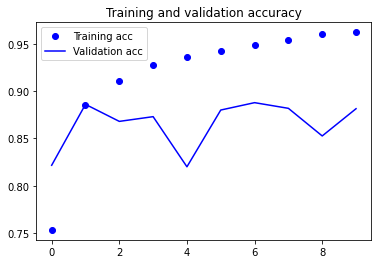

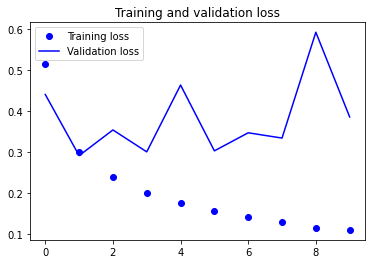

In [ ]:
plot_loss_accuracy(history)

With this approach we achieved up to 89% accuracy, which is not bad. It's certainly much better than the previous `SimpleRNN` approach, but only slightly better than the fully connected network used in chapter 3 (even though this time we are looking at less data). Some considerations:

- LSTM suffers much less from the _gradient vanishing_ problem;
- We made no effort in tuning hyperparameters such embedding dimensionality or LSTM output dimensionality;
- LSTM isn't really helpful for a sentiment analysis problem. Such a basic problem is well solved by looking at what words occurs in each review (and at what frequency), and that's what the fully connected approach looked at;